In [1]:
import sys
import cuentitas
from entornomaximo import entornoMaximo as em
from auxiliares import integracionGauss as ig
from auxiliares import medicion
from auxiliares import sigma
from auxiliares import sigmaEmi
from auxiliares import S0VV_completo
from auxiliares import generador, generador1E, generadorEmisividad

from numpy import pi, sqrt, sin, cos, exp, log10, array, real, conj
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import interpolate
import seaborn as sns
import pandas as pd
import glob
import theano.tensor as TT
import random

import pymc3 as pm

sns.set() #seaborn como default

m = 51 #valores que siempre uso
X,Y,Wt = ig(m-1)

In [5]:
#para usar en modelo() si ignoro la emisividad
def toFit(ep1,ep2,d,s1,l1,s2,l2,angulo):
    landa = 0.025
    k0 = 2*np.pi/landa
    phi = np.pi
    
    ### s0
    phs = phi + np.pi
    thi = angulo  #cambiar segun la zona
    thi = thi*np.pi/180 #DU2 T008, T061, T021
    ths = thi
    k1 = k0*(sin(ths)*cos(phs)-sin(thi)*cos(phi))
    k2 = k0*(sin(ths)*sin(phs)-sin(thi)*sin(phi))
 
    aux = 4*np.pi*k0**2*cos(ths)**2*(abs(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s1,l1,k1,k2)+\
            abs(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s2,l2,k1,k2)+\
            2*real(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d)*conj(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d)))*cuentitas.w_f1f2(s1,l1,s2,l2,k1,k2))
    s0s = 10*np.log10(aux)
    
    nn = len(angulo)
    
    a = TT.zeros(nn)
    print(s0s, type(s0s))
    for i in range(nn):
        a = TT.set_subtensor(a[i], s0s[i])
        
#    aa = TT.set_subtensor(a[0], s0s[0])
#    aaa = TT.set_subtensor(aa[1], s0s[1])
#    aaaa = TT.set_subtensor(aaa[2], s0s[2])
    
    
 
    return a

In [6]:
#para usar en modelo() si quiero con emisividad
def toFitEmis(ep1,ep2,d,s1,l1,s2,l2,anguloWR,anguloR): #Me devuelve un tensor de nn+mm, con nn valores de angulos s0 y mm emis
    landa = 0.025
    k0 = 2*np.pi/landa
    phi = np.pi
    
    ### s0
    phs = phi + np.pi
    thi = anguloR  #cambiar segun la zona
    thi = thi*np.pi/180 #DU2 T008, T061, T021
    ths = thi
    k1 = k0*(sin(ths)*cos(phs)-sin(thi)*cos(phi))
    k2 = k0*(sin(ths)*sin(phs)-sin(thi)*sin(phi))
 
    aux = 4*np.pi*k0**2*cos(ths)**2*(abs(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s1,l1,k1,k2)+\
            abs(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s2,l2,k1,k2)+\
            2*real(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d)*conj(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d)))*cuentitas.w_f1f2(s1,l1,s2,l2,k1,k2))
    s0s = 10*np.log10(aux)

    ### Emisividad
    thiEm = anguloWR*np.pi/180

    ths_ = (X+1)*np.pi/4
    phs_ = (Y+1)*np.pi
    
    ths_1 = np.reshape(ths_, (1,m**2))
    phs_1 = np.reshape(phs_, (1,m**2))
    
    emi = []
    for tt in thiEm:
        q = (np.sin(ths_1)*S0VV_completo(k0,tt,phi,ths_1,phs_1,ep1,ep2,d,s1,l1,s2,l2))
        aux = Wt*q
        I_gauss = (np.pi**2/4)*aux.sum()
 
        emi.append(1 - (I_gauss/(4*np.pi)))
    
    ###
    nn = len(anguloR)
    mm = len(anguloWR)
    pp = nn+mm

    a = TT.zeros(pp)
    for i in range(nn):
        a = TT.set_subtensor(a[i], s0s[i])
    
    for j in range(mm):
        a = TT.set_subtensor(a[nn+j], emi[j])
    
    return a


In [7]:
# angWR es el angulo sin ruido para simulaciones con emisividad, es indistinto el valor 
# que tome si uso la f() sin emisividad
def modelo(sector, angWR, samples, sigmas): 
 
    landa = 0.025
    k0 = 2*np.pi/landa
    phi = np.pi

    
    ranges = {}
    ranges['ep1'] = 1.4, 8
    ranges['s1'] = 0.0004, 0.004
 
    with pm.Model() as model:
        ep1 = pm.Uniform('ep1', ranges['ep1'][0], ranges['ep1'][1])
        s1 = pm.Uniform('s1', ranges['s1'][0], ranges['s1'][1])

     ### Usar este si ignoro emisividad
#    def f(ep1 = ep1, 
#          s1 = s1):
#        return toFit(ep1,3,0.05,s1,0.015,0.001,0.015,sector[0])

    def f(ep1 = ep1, 
          s1 = s1):
        return toFitEmis(ep1,3,0.05,s1,0.015,0.001,0.015,angWR,sector[0])


#    print('angulos usados: ', sector[0])
    
    with model:
        function_pm = pm.Deterministic('s0f', f())
        observations = pm.Normal( "obs",  mu=real(function_pm), sigma=sigmas, observed=sector[1])
        trace = pm.sample_smc(samples)  
    
    return trace

In [7]:
#n = 11
#[angGen, valGen] = generador(n)
#print(angGen)
#print(valGen)
#valRui = valGen + 0.1*np.random.randn(-1,1,len(valGen))
#print(valRui)

In [154]:
# 'se' son los valores reales del modelo, 1 s0 para cada angulo y si es generador1E da 1 emisividad en nadir
# o si es generadorEmisividad da la misma cantidad de emisividades evaluado en cada thi
# 'seR' son los valores de s0 perturbados segun noiseSTD, estos estan en la cantidad de antes pero 
# multiplicados por 'n', en cuanto a la emisividad aparecen las mismas cantidades que antes

C = 7
#[ang,se] = generador1E(C) 
[ang,se] = generadorEmisividad(C) #genera una emisividad para cada angulo
val = se[:len(ang)]
emi = se[len(ang):]

val = np.reshape(val,(len(val),1))
n = 7
snrDB = 10 
snr = 10**(snrDB/10) #escala lineal

psignal = np.mean(val**2) #potencia promedio (db)

noiseSTD =  np.sqrt(psignal/snr)

valRui = np.kron(val,np.ones((n,1))) + noiseSTD*np.random.randn(n*len(val),1)

angR = np.reshape(ang,(len(ang),1))
angR = np.kron(angR,np.ones((n,1)))

angR = np.reshape(angR, (len(angR)))
valR = np.reshape(valRui, (len(valRui)))

emi = np.reshape(emi,(len(emi),1))
emiRui = emi + 0.001*np.random.randn(len(emi),1)
emiR = np.reshape(emiRui,(len(emi)))

seR = np.concatenate((valR,emiR))

In [144]:
# print(ang)
# print(angR)
# print(se,seR)

[10.51278849 10.51278849 10.51278849 10.51278849 10.51278849 10.28103423
 10.28103423 10.28103423 10.28103423 10.28103423 11.69164985 11.69164985
 11.69164985 11.69164985 11.69164985 13.53522891 13.53522891 13.53522891
 13.53522891 13.53522891 15.4690258  15.4690258  15.4690258  15.4690258
 15.4690258 ]
[-4.83552532 -4.74567902 -5.32676064 -6.21216407 -7.29899822  0.98651434
  0.98646634  0.98677966  0.98726895  0.98788493] [-5.55347188 -4.87645847 -3.98976384 -7.14969798 -6.44193559 -3.90563876
 -4.36813626 -5.11758111 -3.43645459 -3.94469641 -5.29693585 -5.54645075
 -6.03006738 -6.71924469 -6.44753059 -6.78687878 -6.44710115 -5.3510331
 -6.4720254  -5.78168106 -7.76058314 -8.58647131 -5.52816034 -7.77156948
 -4.52505079  0.98744415  0.98716177  0.98728164  0.98810929  0.98940271]


In [155]:
m = 51
X,Y,Wt = ig(m-1)

zonaMed = 'HU2'
muestras = 500

# ###error para generador()
# sig = noiseSTD**2
# traza = modelo([angR,seR],muestras,sig) # ¡cambiar la funcion f dentro de modelo() si se usa esto!

#  ###vector de errores para generador1E()
# sig = np.asarray(len(angR)*[noiseSTD**2] + [0.001])
# traza = modelo([angR,seR],np.asarray([0.001]),muestras,sig)
 
###vector de errores para generadorEmisividad()
sig = np.asarray(len(angR)*[noiseSTD**2] + len(ang)*[0.001])
traza = modelo([angR,seR],ang,muestras,sig)


Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.008 Steps:  25 Acce: 0.469
Stage:   2 Beta: 0.049 Steps:   7 Acce: 0.290
Stage:   3 Beta: 0.226 Steps:  13 Acce: 0.179
Stage:   4 Beta: 0.697 Steps:  23 Acce: 0.101
Stage:   5 Beta: 1.000 Steps:  25 Acce: 0.073


In [156]:
e1 = traza['ep1']
s1 = traza['s1']

guardar = [e1,s1]

f = np.savetxt('C='+str(C)+'n='+str(n)+'.txt', guardar, delimiter=';')
f2 = np.savetxt('C='+str(C)+'n='+str(n)+'-input.txt', np.asarray([np.asarray(ang),np.asarray(se),np.asarray(seR)],dtype=object), fmt='%s', delimiter=';')
print('Archivo guardado')


Archivo guardado


Ploteando...


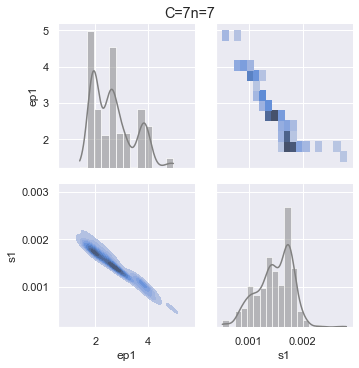

In [157]:
#Ploteo
print('Ploteando...')

plotear = np.stack((traza['ep1'], traza['s1'])).T
dfplotear = pd.DataFrame(plotear, columns = ['ep1','s1'])

g = sns.PairGrid(dfplotear)
g.fig.suptitle('C='+str(C)+'n='+str(n), y=1.01, fontsize = 'large')
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')
g.savefig('C='+str(C)+'n='+str(n)+'.png')


paso  0  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.028 Steps:  25 Acce: 0.450
Stage:   2 Beta: 0.223 Steps:   7 Acce: 0.328
Stage:   3 Beta: 1.000 Steps:  11 Acce: 0.187
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  1  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.026 Steps:  25 Acce: 0.472
Stage:   2 Beta: 0.197 Steps:   7 Acce: 0.329
Stage:   3 Beta: 1.000 Steps:  11 Acce: 0.161
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  2  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.032 Steps:  25 Acce: 0.471
Stage:   2 Beta: 0.232 Steps:   7 Acce: 0.311
Stage:   3 Beta: 1.000 Steps:  12 Acce: 0.148
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  3  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.031 Steps:  25 Acce: 0.480
Stage:   2 Beta: 0.221 Steps:   7 Acce: 0.311
Stage:   3 Beta: 1.000 Steps:  12 Acce: 0.128
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  4  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.034 Steps:  25 Acce: 0.499
Stage:   2 Beta: 0.297 Steps:   6 Acce: 0.284
Stage:   3 Beta: 1.000 Steps:  13 Acce: 0.162
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  5  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.032 Steps:  25 Acce: 0.473
Stage:   2 Beta: 0.239 Steps:   7 Acce: 0.276
Stage:   3 Beta: 1.000 Steps:  14 Acce: 0.186
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  6  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.033 Steps:  25 Acce: 0.503
Stage:   2 Beta: 0.235 Steps:   6 Acce: 0.307
Stage:   3 Beta: 1.000 Steps:  12 Acce: 0.131
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  7  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.032 Steps:  25 Acce: 0.472
Stage:   2 Beta: 0.230 Steps:   7 Acce: 0.305
Stage:   3 Beta: 1.000 Steps:  12 Acce: 0.161
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  8  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.024 Steps:  25 Acce: 0.468
Stage:   2 Beta: 0.173 Steps:   7 Acce: 0.328
Stage:   3 Beta: 1.000 Steps:  11 Acce: 0.173
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  9  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.023 Steps:  25 Acce: 0.444
Stage:   2 Beta: 0.179 Steps:   7 Acce: 0.383
Stage:   3 Beta: 1.000 Steps:   9 Acce: 0.162
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  10  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.033 Steps:  25 Acce: 0.498
Stage:   2 Beta: 0.283 Steps:   6 Acce: 0.259
Stage:   3 Beta: 1.000 Steps:  15 Acce: 0.181
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  11  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.027 Steps:  25 Acce: 0.445
Stage:   2 Beta: 0.195 Steps:   7 Acce: 0.293
Stage:   3 Beta: 1.000 Steps:  13 Acce: 0.164
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  12  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.026 Steps:  25 Acce: 0.481
Stage:   2 Beta: 0.183 Steps:   7 Acce: 0.303
Stage:   3 Beta: 1.000 Steps:  12 Acce: 0.162
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  13  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.030 Steps:  25 Acce: 0.478
Stage:   2 Beta: 0.234 Steps:   7 Acce: 0.315
Stage:   3 Beta: 1.000 Steps:  12 Acce: 0.177
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  14  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.023 Steps:  25 Acce: 0.458
Stage:   2 Beta: 0.189 Steps:   7 Acce: 0.314
Stage:   3 Beta: 1.000 Steps:  12 Acce: 0.154
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  15  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.025 Steps:  25 Acce: 0.469
Stage:   2 Beta: 0.200 Steps:   7 Acce: 0.300
Stage:   3 Beta: 1.000 Steps:  12 Acce: 0.170
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  16  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.028 Steps:  25 Acce: 0.473
Stage:   2 Beta: 0.198 Steps:   7 Acce: 0.291
Stage:   3 Beta: 1.000 Steps:  13 Acce: 0.172
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  17  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.023 Steps:  25 Acce: 0.509
Stage:   2 Beta: 0.185 Steps:   6 Acce: 0.314
Stage:   3 Beta: 1.000 Steps:  12 Acce: 0.161
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  18  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.022 Steps:  25 Acce: 0.475
Stage:   2 Beta: 0.174 Steps:   7 Acce: 0.313
Stage:   3 Beta: 1.000 Steps:  12 Acce: 0.150
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...
paso  19  de  20


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.030 Steps:  25 Acce: 0.489
Stage:   2 Beta: 0.223 Steps:   6 Acce: 0.300
Stage:   3 Beta: 1.000 Steps:  12 Acce: 0.154
C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Archivo guardado
Ploteando...


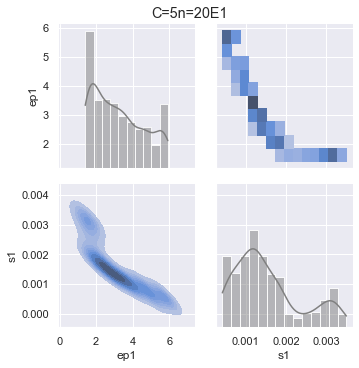

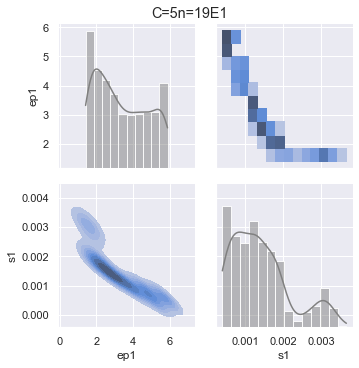

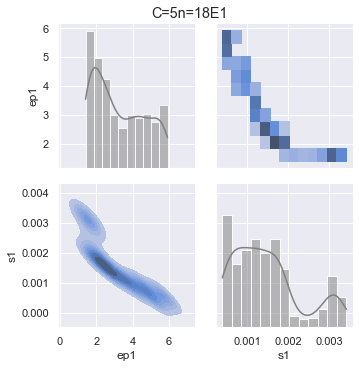

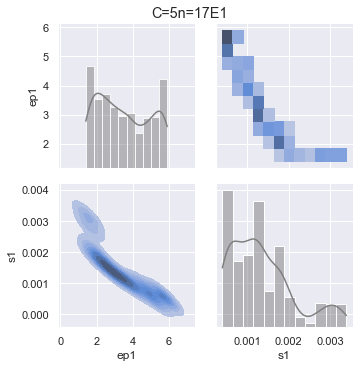

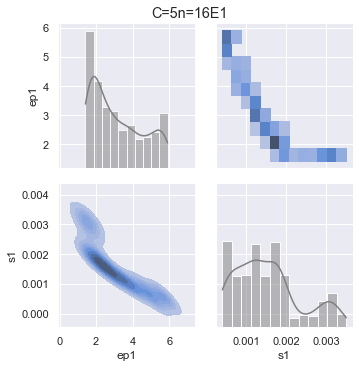

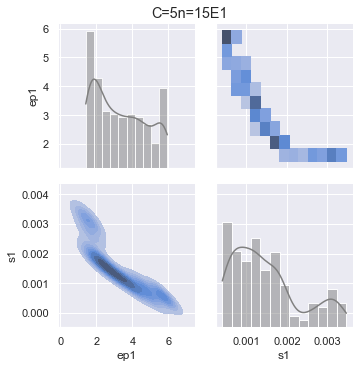

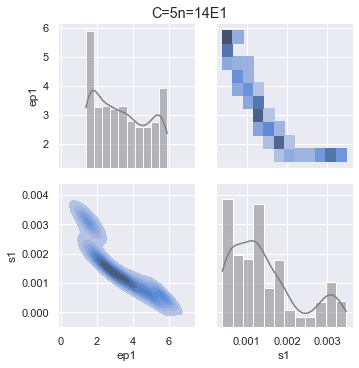

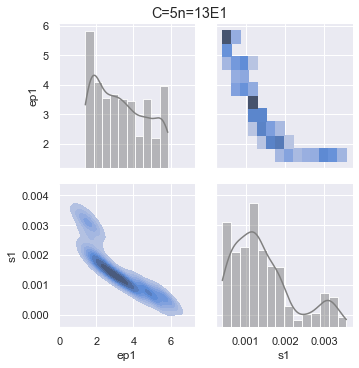

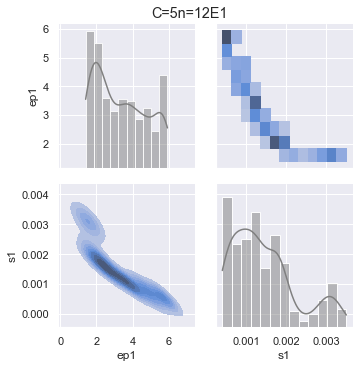

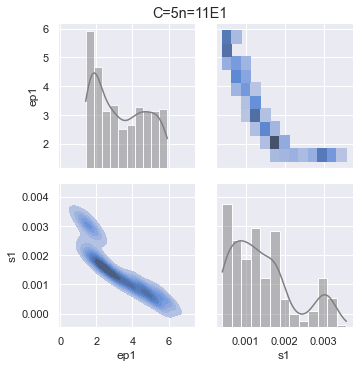

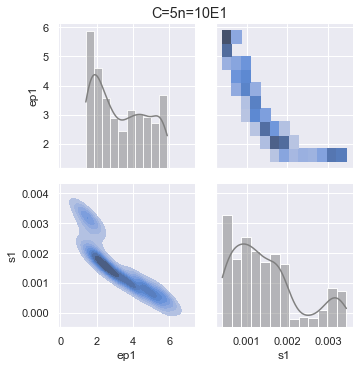

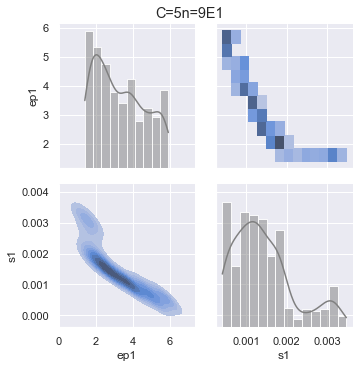

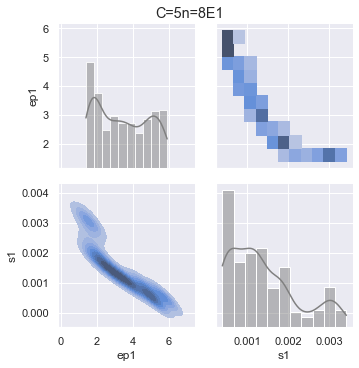

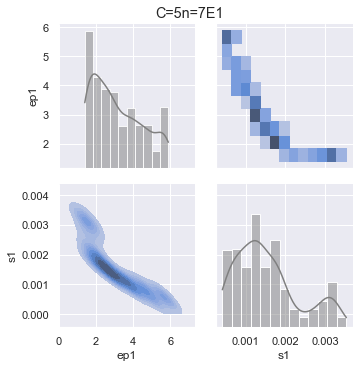

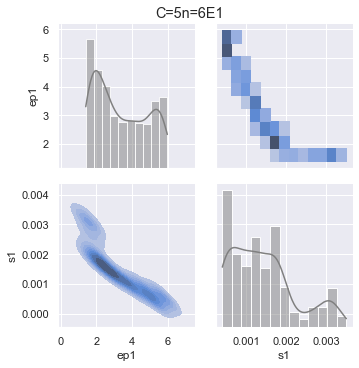

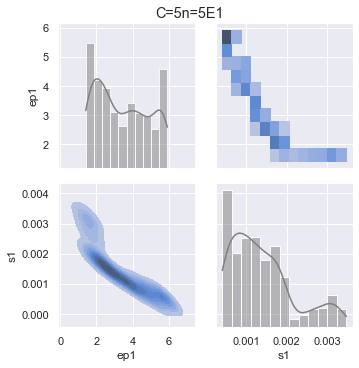

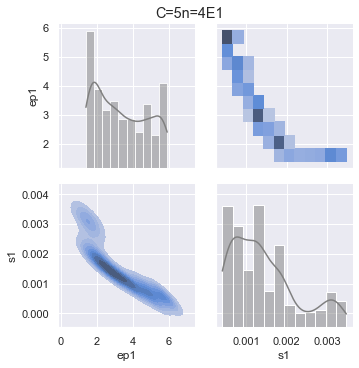

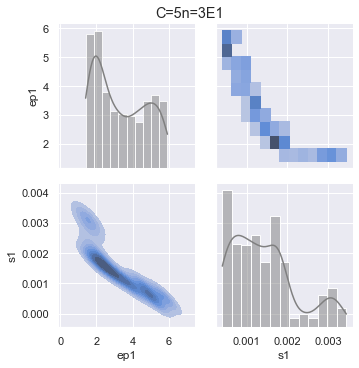

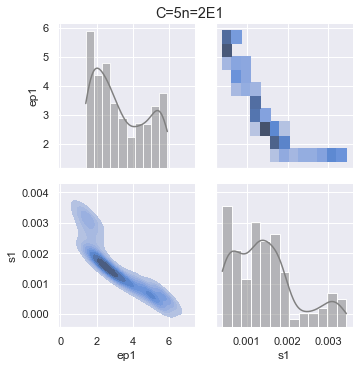

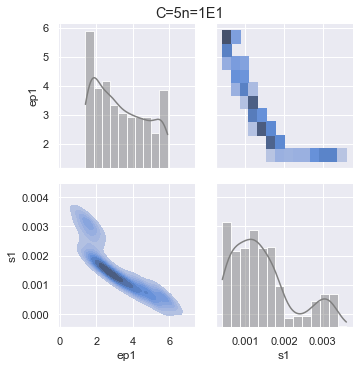

In [127]:
#genera ploteo usando generador1E() variando n a C fijo.

#vario n
def selector(seR,angR,C,n,i):
    N = np.reshape(angR,(C,n))
    N = N[:,i:]
    N = np.reshape(N,(len(N[0,:])*len(N[:,0])))
    
    M = np.reshape(seR[:-1],(C,n))
    M = M[:,i:]
    M = np.reshape(M,(len(M[0,:])*len(M[:,0])))
    return [N,np.concatenate((M, [seR[-1]]), axis=0)]

for i in range(n): 
    print('paso ',i,' de ',n)
    [angAux,seRaux] = selector(seR,angR,C,n,i)

    sigm = np.asarray(len(angR)*[noiseSTD**2] + [0.001])
    traza = modelo([angR,seR],np.asarray([0.001]),500,sigm)

    e1 = traza['ep1']
    s1 = traza['s1']
    guardar = [e1,s1]
    guardar2 = np.asarray([angAux,seRaux], dtype=object)
    f = np.savetxt('Emisividad-VariandoN/C='+str(C)+'n='+str(n-i)+'E1.txt', guardar, delimiter=';')
    f2 = np.savetxt('Emisividad-VariandoN/C='+str(C)+'n='+str(n-i)+'E1-input.txt', guardar2, fmt='%s', delimiter=';')


    print('Archivo guardado')

    #Ploteo
    print('Ploteando...')

    plotear = np.stack((traza['ep1'], traza['s1'])).T
    dfplotear = pd.DataFrame(plotear, columns = ['ep1','s1'])

    g = sns.PairGrid(dfplotear)
    g.fig.suptitle('C='+str(C)+'n='+str(n-i)+'E1', y=1.01, fontsize = 'large')
    g.map_upper(sns.histplot)
    g.map_lower(sns.kdeplot, fill=True)
    g.map_diag(sns.histplot, kde=True, color='.5')
    g.savefig('Emisividad-VariandoN/C='+str(C)+'n='+str(n-i)+'E1.png')
     
np.savetxt('Emisividad-VariandoN/C='+str(C)+'n='+str(n)+'E1-input.txt', [ang,se], fmt='%s', delimiter=';')

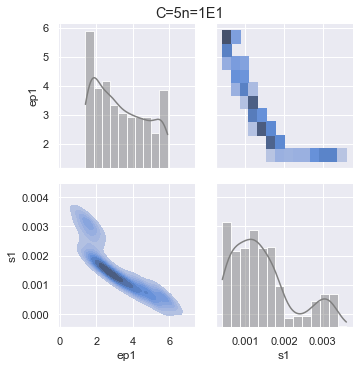

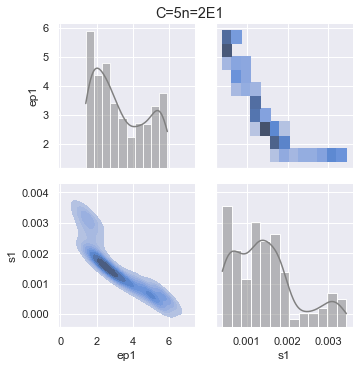

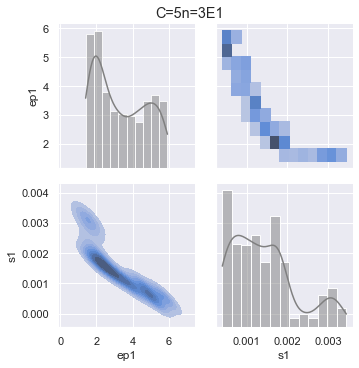

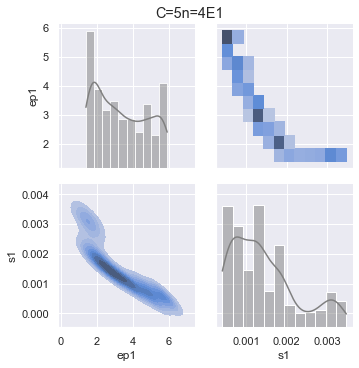

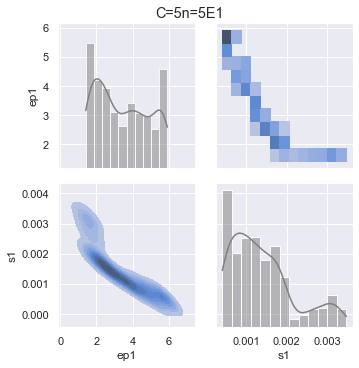

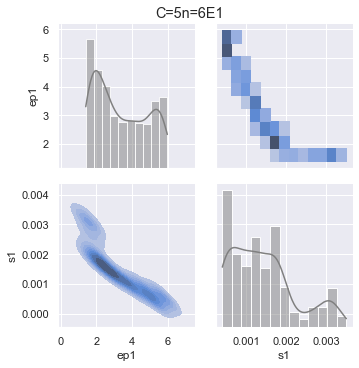

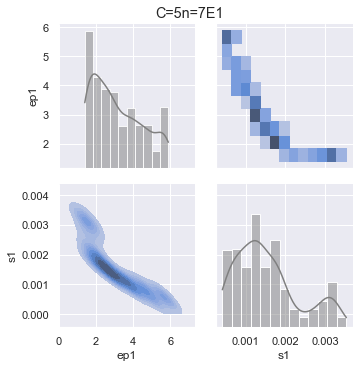

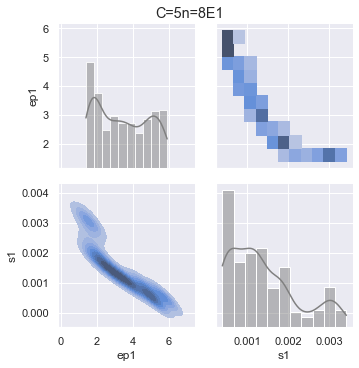

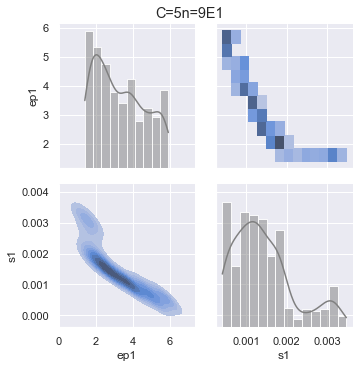

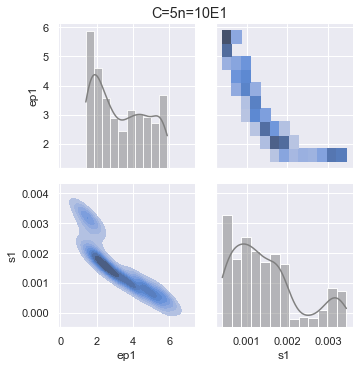

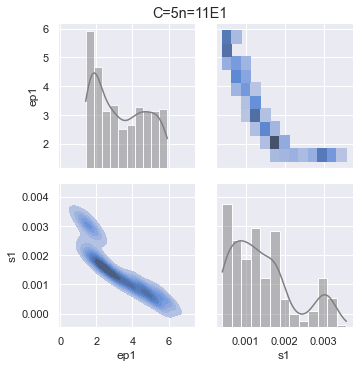

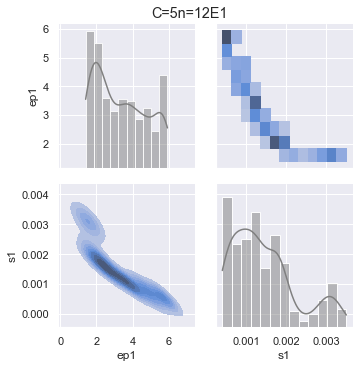

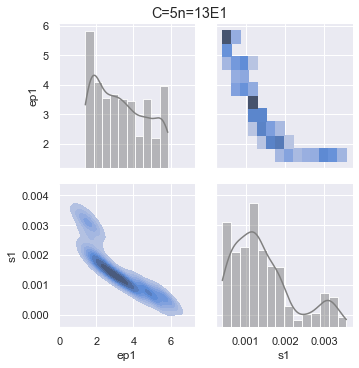

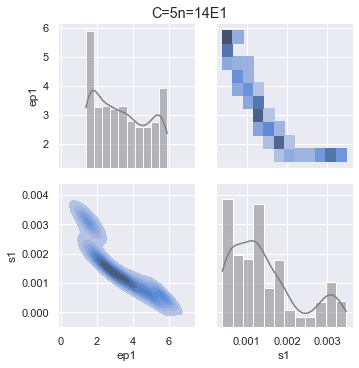

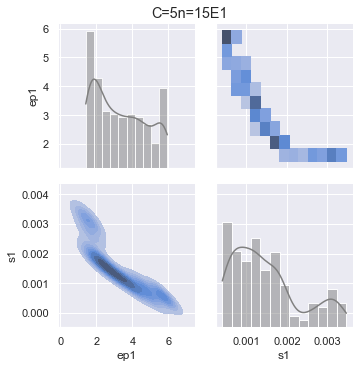

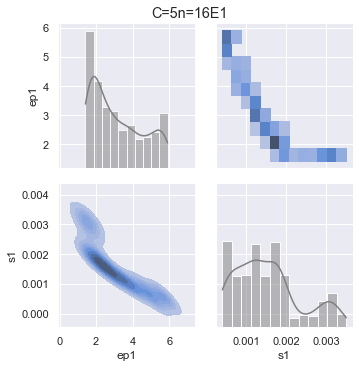

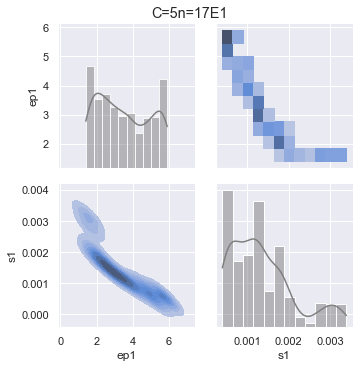

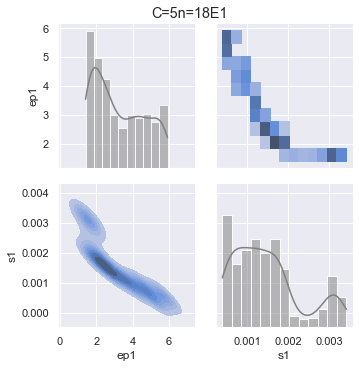

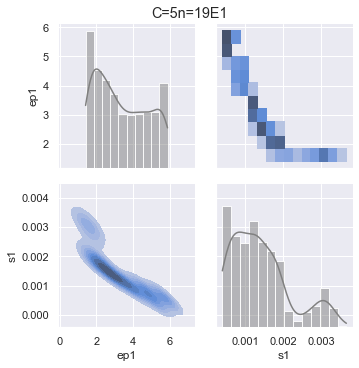

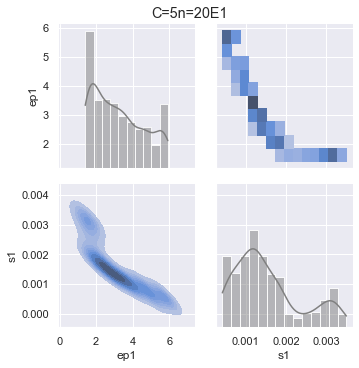

In [132]:
# para plotear los datos con n = 20

for i in range(1,21):
    load = np.loadtxt('Emisividad-VariandoN/C=5n='+str(i)+'E1.txt', delimiter=';')
    e = load[0]
    s = load[1]
    
    plotear = np.stack((e, s)).T
    dfplotear = pd.DataFrame(plotear, columns = ['ep1','s1'])
    
    g = sns.PairGrid(dfplotear)
    g.fig.suptitle('C='+str(C)+'n='+str(i)+'E1', y=1.01, fontsize = 'large')
    g.map_upper(sns.histplot)
    g.map_lower(sns.kdeplot, fill=True)
    g.map_diag(sns.histplot, kde=True, color='.5')
    g.savefig('Emisividad-VariandoN/C=5n='+str(i)+'E1.png')

In [ ]:
# genera trazas reduciendo las mediciones del modelo sin emisividad, guarda datos y ploteo
    
#[angGen, valGen] = generador(11)


for i in range(len(angGen)-1): 
    
    traza = modelo([angGen[:-i-1],valGen[:-i-1]],10000,0.1)

    e1 = traza['ep1']
    s1 = traza['s1']
    guardar = [e1,s1]

    f = np.savetxt('Sigma/N'+str(i)+'.txt', guardar, delimiter=';')
    f2 = np.savetxt('Sigma/N'+str(i)+'-input.txt', [angGen,valGen], delimiter=';')
    print('Archivo guardado')

    #Ploteo
    print('Ploteando...')

    plotear = np.stack((traza['ep1'], traza['s1'])).T
    dfplotear = pd.DataFrame(plotear, columns = ['ep1','s1'])

    g = sns.PairGrid(dfplotear)
    g.fig.suptitle('N='+str(len(angGen)-i), y=1.01, fontsize = 'large')
    g.map_upper(sns.histplot)
    g.map_lower(sns.kdeplot, fill=True)
    g.map_diag(sns.histplot, kde=True, color='.5')
    g.savefig('Sigma/N'+str(i)+'.png')


In [151]:
pru = np.loadtxt('prueba-e1s1.txt', delimiter=';') #output del sampler

(0.0004, 0.002)

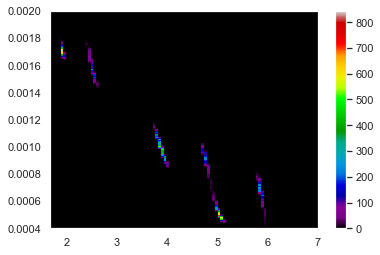

In [153]:
# histograma 2d 
xx = pru[0]
yy = pru[1]
x_bins = np.linspace(np.min(xx), np.max(xx), 100)
y_bins = np.linspace(np.min(yy), np.max(yy), 500)
plt.hist2d(xx,yy,bins=[x_bins,y_bins],cmap = plt.cm.nipy_spectral)
plt.colorbar()
plt.ylim(0.0004,0.002)
# plt.figure()
# plt.hexbin(xx,yy,bins=500,cmap = plt.cm.nipy_spectral)
# plt.colorbar()
# plt.ylim(0.0004,0.002)


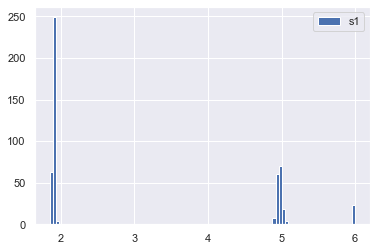

In [75]:
y, x, _ = plt.hist(traza['ep1'],bins=100, label='s1')
plt.legend()

In [134]:
 ###ploteos sigma0 y emisividad vs ep1,ep2,s1

def plotear1(ep1,ep2,s1,ang):
    return 10*np.log10(S0VV_completo(2*np.pi/0.025,ang*np.pi/180,np.pi,ang*np.pi/180,2*np.pi,ep1,ep2,0.05,s1,0.015,0.001,0.015))

def plotear2(ep1,ep2,s1,ang):
    return 10*np.log10(S0VV_completo(2*np.pi/0.025,ang*np.pi/180,np.pi,ang*np.pi/180,2*np.pi,ep1,ep2,0.05,s1,0.015,0.001,0.015))

def plotEmi1(ep1,ep2,s1,ang):
    ep1 = np.asarray(ep1)
    ep2 = np.asarray(ep2)
    s1 = np.asarray(s1)
    emiPlot = []
    for epp in ep1:
        for ssp in s1:
            for e2 in ep2:
                emiPlot.append(sigmaEmi(epp,e2,0.05,ssp,0.015,0.001,0.015,ang,X,Y,Wt,m)[1])
    return emiPlot

def plotEmi2(ep1,ep2,s1,ang):
    
    emiPlot = []
    for epp in ep1:
        for ssp in s1:
            for e2 in ep2:
                emiPlot.append(sigmaEmi(epp,e2,0.05,ssp,0.015,0.001,0.015,ang,X,Y,Wt,m)[1])
    return emiPlot

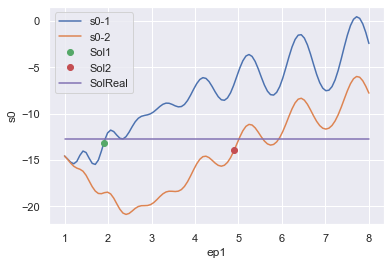

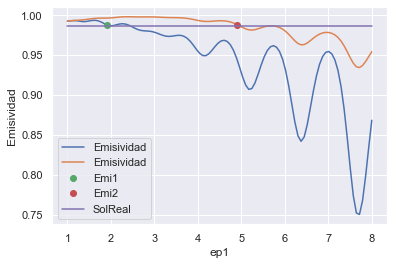

In [135]:
#graficos del modelo spm para s0 y emisividad variando ep1
valorReal = -12.74875174
ang = 22.63549614
valorEmi = 0.98667734
angEmi = 13.65155455

epsilon1 = np.linspace(1,8,100)
s1 = np.linspace(0.0002, 0.006,100)
plt.figure()

plt.plot(epsilon1, plotear1(epsilon1,3,0.0017,ang),label='s0-1')
plt.plot(epsilon2, plotear2(epsilon1,3,0.00055,ang),label='s0-2')
plt.plot(1.9, plotear1(1.9,3,0.0017,ang),'o',label='Sol1')
plt.plot(4.9,plotear2(4.9,3,0.00055,ang),'o',label='Sol2')
plt.plot(epsilon1,100*[valorReal],label='SolReal')
plt.xlabel('ep1')
plt.ylabel('s0')
plt.legend()

plt.figure()

plt.plot(epsilon1, plotEmi1(epsilon1,[3],[0.0017],angEmi),label='Emisividad')
plt.plot(epsilon1, plotEmi2(epsilon1,[3],[0.00055],angEmi),label='Emisividad')
plt.plot(1.9, plotEmi1([1.9],[3],[0.0017],angEmi),'o',label='Emi1')
plt.plot(4.9, plotEmi2([4.9],[3],[0.00055],angEmi),'o',label='Emi2')
plt.plot(epsilon1,100*[valorEmi],label='SolReal')
plt.xlabel('ep1')
plt.ylabel('Emisividad')
plt.legend()

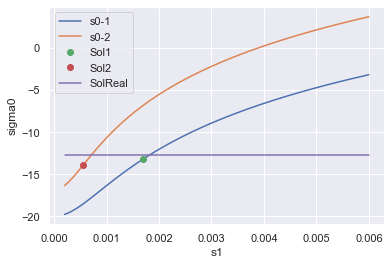

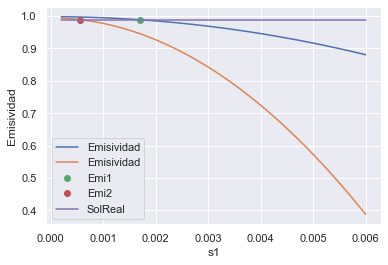

In [141]:
#graficos del modelo spm para s0 y emisividad variando s1

s1 = np.linspace(0.0002, 0.006,100)
plt.figure()
plt.plot(s1, plotear1(1.9,3,s1,ang),label='s0-1')
plt.plot(s1, plotear2(4.9,3,s1,ang),label='s0-2')
plt.plot(0.0017, plotear1(1.9,3,0.0017,ang),'o',label='Sol1')
plt.plot(0.00055,plotear2(4.9,3,0.00055,ang),'o',label='Sol2')
plt.plot(s1,100*[valorReal],label='SolReal')
plt.xlabel('s1')
plt.ylabel('sigma0')
plt.legend()

plt.figure()

plt.plot(s1, plotEmi1([1.9],[3],s1,angEmi),label='Emisividad')
plt.plot(s1, plotEmi2([4.9],[3],s1,angEmi),label='Emisividad')
plt.plot(0.0017, plotEmi1([1.9],[3],[0.0017],angEmi),'o',label='Emi1')
plt.plot(0.00055, plotEmi2([4.9],[3],[0.00055],angEmi),'o',label='Emi2')
plt.plot(s1,100*[valorEmi],label='SolReal')
plt.xlabel('s1')
plt.ylabel('Emisividad')
plt.legend()

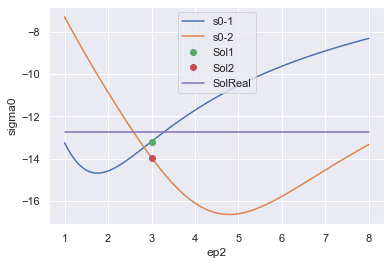

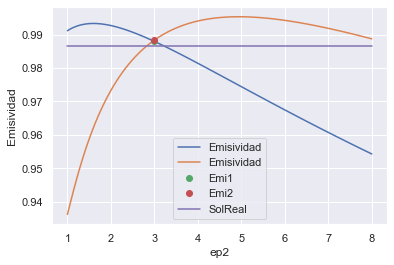

In [146]:
#graficos del modelo spm para s0 y emisividad variando ep2

ep2 = np.linspace(1,8,100)
plt.figure()
plt.plot(ep2, plotear1(1.9,ep2,0.0017,ang),label='s0-1')
plt.plot(ep2, plotear2(4.9,ep2,0.00055,ang),label='s0-2')
plt.plot(3, plotear1(1.9,3,0.0017,ang),'o',label='Sol1')
plt.plot(3,plotear2(4.9,3,0.00055,ang),'o',label='Sol2')
plt.plot(ep2,100*[valorReal],label='SolReal')
plt.xlabel('ep2')
plt.ylabel('sigma0')
plt.legend()

plt.figure()

plt.plot(ep2, plotEmi1([1.9],ep2,[0.0017],angEmi),label='Emisividad')
plt.plot(ep2, plotEmi2([4.9],ep2,[0.00055],angEmi),label='Emisividad')
plt.plot(3, plotEmi1([1.9],[3],[0.0017],angEmi),'o',label='Emi1')
plt.plot(3, plotEmi2([4.9],[3],[0.00055],angEmi),'o',label='Emi2')
plt.plot(ep2,100*[valorEmi],label='SolReal')
plt.xlabel('ep2')
plt.ylabel('Emisividad')
plt.legend()

----------------
+ Pruebas extras

In [53]:
#Genero los valores del modelo para estos angulos incidentes
angPrueba = [10,15,20]

for i in angPrueba:
    print('thi = ',i,': ',prueba(1.93,3,0.05,0.0017,0.015,0.001,0.015,i))

#esto es lo que devuelve
back = [-4.639,-7.020,-10.492]

thi =  10 :  (-4.639658114654706, 0.9854867397806576)
thi =  15 :  (-7.020294116808399, 0.9854867397806576)
thi =  20 :  (-10.492452448846416, 0.9854867397806576)


In [7]:
def prueba(ep1,ep2,d,s1,l1,s2,l2,angulo): #funcion de antes pero sin la parte tensorial
    landa = 0.025
    k0 = 2*np.pi/landa
    phi = np.pi
    ### s0
    phs = phi + np.pi
    thi = angulo  #cambiar segun la zona
    thi = thi*np.pi/180 #DU2 T008, T061, T021
    ths = thi
    k1 = k0*(sin(ths)*cos(phs)-sin(thi)*cos(phi))
    k2 = k0*(sin(ths)*sin(phs)-sin(thi)*sin(phi))
 
    aux = 4*np.pi*k0**2*cos(ths)**2*(abs(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s1,l1,k1,k2)+\
            abs(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s2,l2,k1,k2)+\
            2*real(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d)*conj(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d)))*cuentitas.w_f1f2(s1,l1,s2,l2,k1,k2))
    s0s = 10*np.log10(aux)
    
    ### emi
    X,Y,Wt = ig(50)
    
    thi = 0.0001*np.pi/180
    
    ths_ = (X+1)*np.pi/4
    phs_ = (Y+1)*np.pi
    
    ths_1 = np.reshape(ths_, (1,m**2))
    phs_1 = np.reshape(phs_, (1,m**2))
    
    q = (np.sin(ths_1)*S0VV_Fran_completo(k0,thi,phi,ths_1,phs_1,ep1,ep2,d,s1,l1,s2,l2))
    aux = Wt*q
    I_gauss = (np.pi**2/4)*aux.sum()
 
    emi = 1 - (I_gauss/(4*np.pi))

    return s0s, emi

In [17]:
print(prueba(4.9,3,0.05,0.0005,0.015,0.001,0.015,1.818436070339912192e+01))
print(prueba(1.9,3,0.05,0.0017,0.015,0.001,0.015,1.818436070339912192e+01))

(-10.779656399752298, 0.9878926451211318)
(-9.448830435966933, 0.9858996818621227)


In [12]:
m = 51

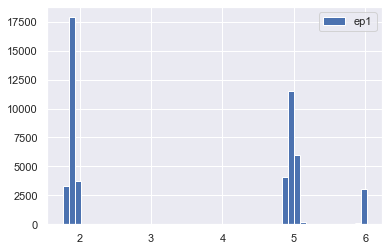

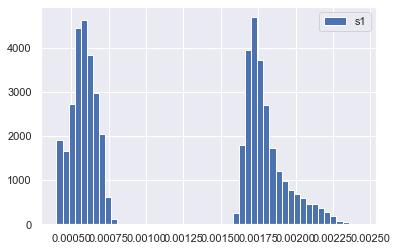

In [10]:
y, x, _ = plt.hist(pru[0],bins=50, label='ep1')
plt.legend()
plt.figure()
y2, x2, _2 = plt.hist(pru[1],bins=50, label='s1')
plt.legend()
y2 = np.asarray(y2)
x2 = np.asarray(x2)

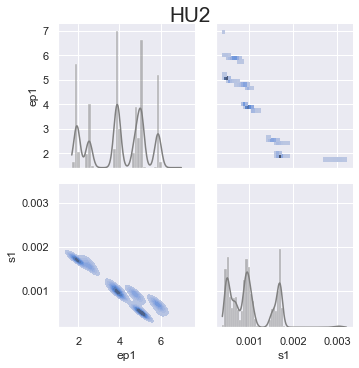

In [41]:
plotear = np.stack((pru[0], pru[1])).T#, traza['d'], traza['s1'], traza['l1'], traza['s2'], traza['l2'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1','s1'])#,'d','s1','l1','s2','l2'])

g = sns.PairGrid(dfplotear)
g.fig.suptitle(zonaMed, y=1.01, fontsize = 'xx-large')
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')

In [57]:
ee = [x[16],x[25],x[1],x[31],x[6],x[23]]
ss = [x2[0],x2[17],x2[6],x2[7]] #Anote cuales son los indices en mi libretita
print(ss)
print(ee)
auxx1 = []
#auxx2 = []
#auxx3 = []
for e in range(len(ee)):
    for s in range(len(ss)):
        print('\n eps1 = ', ee[e],' - s1 = ',ss[s])
        print(prueba(ee[e],3,0.05,ss[s],0.015,0.001,0.015,10))
        print(prueba(ee[e],3,0.05,ss[s],0.015,0.001,0.015,15))
        print(prueba(ee[e],3,0.05,ss[s],0.015,0.001,0.015,20))
        auxx1.append(prueba(ee[e],3,0.05,ss[s],0.015,0.001,0.015,10))
        auxx2.append(prueba(ee[e],3,0.05,ss[s],0.015,0.001,0.015,15))
        auxx3.append(prueba(ee[e],3,0.05,ss[s],0.015,0.001,0.015,20))

[0.0004003661684850914, 0.0015933870327917662, 0.0008214323558874472, 0.0008916100537878398]
[3.8103828506473536, 5.010116979069004, 1.8108259699446037, 5.809939731350104, 2.4773449301788535, 4.7435093949753036]

 eps1 =  3.8103828506473536  - s1 =  0.0004003661684850914
(-11.68975125587416, 0.996605331381465)
(-14.131996961065491, 0.996605331381465)
(-17.41114349391433, 0.996605331381465)

 eps1 =  3.8103828506473536  - s1 =  0.0015933870327917662
(-1.568720644678945, 0.9658951697526235)
(-4.008483984991635, 0.9658951697526235)
(-7.266854220634632, 0.9658951697526235)

 eps1 =  3.8103828506473536  - s1 =  0.0008214323558874472
(-6.907396236715274, 0.9899631209595513)
(-9.347806265855676, 0.9899631209595513)
(-12.611578292297608, 0.9899631209595513)

 eps1 =  3.8103828506473536  - s1 =  0.0008916100537878398
(-6.277875294667168, 0.9884109845093717)
(-8.718161977041898, 0.9884109845093717)
(-11.9809031073586, 0.9884109845093717)

 eps1 =  5.010116979069004  - s1 =  0.0004003661684850914

In [65]:
indices = [2,3,4,9,12,14,15,17,22,23]

auxx1 = np.asarray(auxx1)
auxx2 = np.asarray(auxx2)
auxx3 = np.asarray(auxx3)
buenos1 = []
buenos2 = []
buenos3 = []
for i in indices:
    buenos1.append(auxx1[i,:])
    buenos2.append(auxx2[i,:])
    buenos3.append(auxx3[i,:])

buenos1 = np.asarray(buenos1)
buenos2 = np.asarray(buenos2)
buenos3 = np.asarray(buenos3)

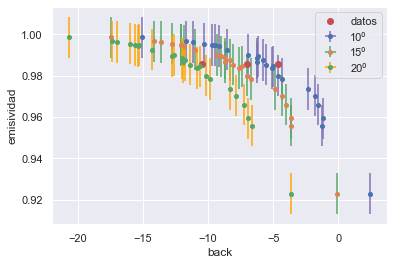

In [30]:
plt.errorbar(auxx1[:,0],auxx1[:,1],yerr=0.01,xerr=0.1,ecolor='m',fmt='o',label='10º',ms=4)
plt.errorbar(auxx2[:,0],auxx2[:,1],yerr=0.01,xerr=0.1,ecolor='g',fmt='o', label ='15º',ms=4)
plt.errorbar(auxx3[:,0],auxx3[:,1],yerr=0.01,xerr=0.1,ecolor='orange',fmt='o', label ='20º',ms=4)
plt.plot([-4.639658114654706,-7.020294116808399,-10.492452448846416],[0.9854867397806576,0.9854867397806576,0.9854867397806576],'or',label='datos')
plt.xlabel('back')
plt.ylabel('emisividad')
plt.legend()

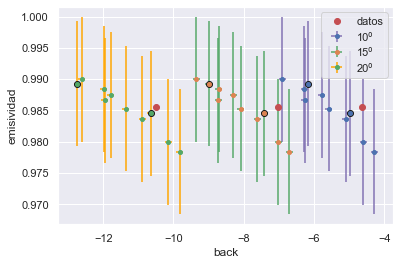

In [69]:
plt.errorbar(buenos1[:,0],buenos1[:,1],yerr=0.01,xerr=0.1,ecolor='m',fmt='o',label='10º',ms=4)
plt.errorbar(buenos2[:,0],buenos2[:,1],yerr=0.01,xerr=0.1,ecolor='g',fmt='o', label ='15º',ms=4)
plt.errorbar(buenos3[:,0],buenos3[:,1],yerr=0.01,xerr=0.1,ecolor='orange',fmt='o', label ='20º',ms=4)
plt.plot([-4.639658114654706,-7.020294116808399,-10.492452448846416],[0.9854867397806576,0.9854867397806576,0.9854867397806576],'or',label='datos')
plt.plot([-6.178722362318685,-8.989390749875275,-12.744122092631088], [0.9892394723818398, 0.9892394723818398, 0.9892394723818398],'ok')
plt.plot([-4.981289712474401,-7.415926189879119,-10.64156325184218],[0.9845078255757418, 0.9845078255757418, 0.9845078255757418],'ok')

plt.xlabel('back')
plt.ylabel('emisividad')
plt.legend()

----------